#### [Exp_05] 프로젝트 : 인공지능과 가위바위보 하기  

### 1. 테스트 준비.  

In [1]:
# 라이브러리 로드.

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob
import seaborn as sns
import math

print(tf.__version__)   # Tensorflow의 버전을 출력


2022-10-03 17:44:12.708514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-03 17:44:12.708570: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.9.1


In [2]:
import random

def random_choice(lists, count):
    return random.choices(population=lists, k=count)

In [3]:
# 가위바위보 데이터를 로드한다.
# 파일 개수만큼 라벨을 생성함.

def load_data(img_path): 
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    
    paper_list = glob.glob(img_path + "/paper/*.jpg")
    rock_list = glob.glob(img_path + "/rock/*.jpg")
    scissor_list = glob.glob(img_path + "/scissor/*.jpg")
    number_of_data = len(paper_list) + len(rock_list) + len(scissor_list)
    
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in paper_list:
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in rock_list:
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in scissor_list:
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("로드된 이미지 개수는", idx,"입니다.")
    return imgs, labels


In [4]:
# 트레인 데이터는 그루님들이 모아준 데이터 사용.
# image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
train_image_dir_path = "/home/evergrin/python/notebook/data/rock_scissor_paper"
(x_train, y_train)=load_data(train_image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

# 테스트 데이터는 aiffel에서 제공하는 test를 사용.
test_image_dir_path = "/home/evergrin/python/notebook/data/rock_scissor_paper/test"
(x_test, y_test)=load_data(test_image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

로드된 이미지 개수는 7560 입니다.
로드된 이미지 개수는 300 입니다.
x_train shape: (7560, 28, 28, 3)
y_train shape: (7560,)
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [5]:
# 여러 데이터들을 각각 resize하여 데이터를 모아줌.

def resize_images(img_path, to_path, prefix):

    images=glob.glob(img_path + "/*.jpg")

    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        file_name = os.path.basename(img)
        # file_name = prefix + "_" + file_name
        file_name = prefix + file_name
        new_path = to_path + file_name
        new_img.save(new_path, "JPEG")

    print(len(images), " images resized.")


In [57]:
# 그루님들의 데이터별로 아래코드를 실행하여 train/test 데이터를 한곳으로 준비한다.
# train은 7530개, test는 300개.
image_dir_path = "/home/evergrin/다운로드/data/scissor/"
to_path = "/home/evergrin/python/notebook/data/rock_scissor_paper/test/scissor/"
resize_images(image_dir_path, to_path, "test")


100  images to be resized.


/tmp/ipykernel_4157/2533997147.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  new_img=old_img.resize(target_size,Image.ANTIALIAS)


100  images resized.
가위 이미지 resize 완료!


In [176]:
# 데이터 정규화 및 3채널에 맞게 reshape 함.

def preprocess_data(x_train, y_train, x_test, y_test, normalize):

    # data normalization
    x_train_norm, x_test_norm = x_train, x_test
    
    if normalize:
        x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0

    # print(f"Before Reshape - x_train_norm shape: {x_train_norm.shape}")
    # print(f"Before Reshape - x_test_norm shape: {x_test_norm.shape}")

    # data reshape
    x_train_reshaped=x_train_norm.reshape( -1, 28, 28, 3)  # 데이터갯수에 -1을 쓰면 reshape시 자동계산됩니다.
    x_test_reshaped=x_test_norm.reshape( -1, 28, 28, 3)

    # print(f"After Reshape - x_train_reshaped shape: {x_train_reshaped.shape}")
    # print(f"After Reshape - x_test_reshaped shape: {x_test_reshaped.shape}")
    
    print("xtrain:", x_train_reshaped.shape, "xtest:", x_test_reshaped.shape)  # x_train 배열의 크기를 출력
    
    return x_train_reshaped, y_train, x_test_reshaped, y_test


In [7]:
# 이미지를 보여주는 함수.

def show_img(ary):
    plt.imshow(ary,cmap=plt.cm.binary)
    plt.show()


In [11]:
# 예측하여 예측된 데이터를 얻어내는 함수.

def predict_model(model, x):
    predicted_result = model.predict(x)  # model이 추론한 확률값. 
    predicted_labels = np.argmax(predicted_result, axis=1)
    
    # 예측한 정답들을 리턴.
    return predicted_labels



In [12]:
# 잘못 예측한 데이터를 랜덤하게 일부 확인하는 함수.

def check_predicted(x, y_true, y_pred):
    
    wrong_predict_list = []

    for i, _ in enumerate(y_pred):
        # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
        if y_pred[i] != y_true[i]:
            wrong_predict_list.append(i)

    # wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
    for n in random_choice(wrong_predict_list, 5):
        print("라벨: " + str(y_true[n]) + ", 예측결과: " + str(y_pred[n]))
        show_img(x[n])

In [143]:
# 학습시 accuracy, loss를 DataFrame에 저장함.

result_df = pd.DataFrame(columns=['num', 'epoch', 'type', 'val'])
test_df = pd.DataFrame(columns=['num', 'title', 'desc'])

def record_result(test_case, no, hist, loss, accuracy):
    
    result = {'num':test_case['num'],'epoch': no, 'type':'loss_tr','val': hist['loss'][0]}
    result_df.loc[len(result_df.index)] = result
    
    result['type'] = 'acc_tr'
    result['val'] = hist['accuracy'][0]
    result_df.loc[len(result_df.index)] = result
    
    result['type'] = 'loss_val'
    result['val'] = hist['val_loss'][0]
    result_df.loc[len(result_df.index)] = result
    
    result['type'] = 'acc_val'
    result['val'] = hist['val_accuracy'][0]
    result_df.loc[len(result_df.index)] = result
    
    result['type'] = 'loss_te'
    result['val'] = loss
    result_df.loc[len(result_df.index)] = result
    
    result['type'] = 'acc_te'
    result['val'] = accuracy
    result_df.loc[len(result_df.index)] = result
    

In [183]:

def learning(model, test_case, x_tr, y_tr, x_te, y_te, epoch_num=3):
        
    test_df.loc[test_case['num']] = test_case.copy()
    
    for no in range(1, epoch_num+1):
        
        hist = model.fit(x_tr, y_tr, epochs=1, verbose=0, validation_split=0.2)
        loss, accuracy = model.evaluate(x_te, y_te, verbose=0)
        
        print('*', end='')
        if no % 10 == 0:
            print(' ', end='')

        record_result(test_case, no, hist.history, loss, accuracy)
        
    print('.')
        
    

In [148]:
# option{'op': name, 'args': [arg list]}
#{'op': "input", 'args': (28,28,3)}
#{'op': "output", 'args': [3, 'softmax']}
#{'op': "conv2d", 'args': [16, 3, 3, 'relu']}
#{'op': "dense", 'args': [16, 'relu']}
#{'op': "maxpool2d", 'args': [2, 2]}
#{'op': "flatten", 'args': []}
#{'op': "batchnormal", 'args': []}
#{'op': "dropout", 'args': [3, 'softmax']}

# option으로 해당 keras.layer를 가져옴.
def get_layer(option):
    
    op = option['op']
    args = option['args']

    if 'input' == op:
        return keras.layers.Input(shape=args[0])

    elif 'output' == op:
        return keras.layers.Dense(args[0], activation=args[1])
    
    elif 'conv2d' == op:
        return keras.layers.Conv2D(args[0], (args[1], args[2]), activation=args[3])
    
    elif 'dense' == op:
        return keras.layers.Dense(args[0], activation=args[1])
    
    elif 'maxpool2d' == op:
        return keras.layers.MaxPool2D(args[0],args[1])
    
    elif 'flatten' == op:
        return keras.layers.Flatten()

    elif 'batchnormal' == op:
        return keras.layers.BatchNormalization()
    
    elif 'dropout' == op:
        return keras.layers.Dropout(args[0])
    
    else:
        raise Exception
    

# options으로 keras.model을 구성함.
def create_model(options, optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    # 모델을 설정.
    model=keras.models.Sequential()
    
    for option in options:
        model.add(get_layer(option))
    
    print('Model Layer 개수: ', len(model.layers))
    # model.summary()
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model


def option_to_str(option):
    return f'{option["op"]}({option["args"]})'

  
def make_option(op, *args):
    return {'op': op, 'args': list(args)}
    


In [173]:
# train/validate/test loss 를 표시함.
def graph_loss():
    
    loss_df = result_df[ (result_df['type'] == 'loss_tr') | (result_df['type'] == 'loss_val') | (result_df['type'] == 'loss_te')  ]

    sns.lineplot(data=loss_df, x='epoch', y="val", hue='type')

    tests = list(loss_df['num'].unique())
    plot_cnt = len(tests)

    fig, axies = plt.subplots(nrows=plot_cnt, ncols=1, figsize=(10, plot_cnt*5))
    if plot_cnt > 1:
        axies = axies.flatten()

    for idx, n in enumerate(tests):
        ax = axies
        if plot_cnt > 1:
            ax = axies[idx]
        ax.set_title(test_df.loc[n, 'title'])
        sns.lineplot(data=loss_df[loss_df['num'] == n], x='epoch', y="val", hue='type', ax=ax)


In [198]:
# train/validate/test accuracy 를 표시함.
def graph_accuracy():

    acc_df = result_df[ (result_df['type'] == 'acc_tr') | (result_df['type'] == 'acc_val') | (result_df['type'] == 'acc_te')  ]

    sns.lineplot(data=acc_df, x='epoch', y="val", hue='type')
    plt.title("accuracy")
    
    tests = list(acc_df['num'].unique())
    plot_cnt = len(tests)

    fig, axies = plt.subplots(nrows=plot_cnt, ncols=1, figsize=(10, plot_cnt*5))
    if plot_cnt > 1:
        axies = axies.flatten()

    for idx, n in enumerate(tests):
        ax = axies
        if plot_cnt > 1:
            ax = axies[idx]
        ax.set_title(f"{n}.{test_df.loc[n, 'title']}")
        sns.lineplot(data=acc_df[acc_df['num'] == n], x='epoch', y="val", hue='type', ax=ax)


### 2. 옵션을 바꿔가며 테스트 진행.

In [184]:
# 테스트 결과를 저장할 DataFrame을 생성.
result_df = pd.DataFrame(columns=['num', 'epoch', 'type', 'val'])
test_df = pd.DataFrame(columns=['num', 'title', 'desc'])
epochnum = 30

In [212]:
# 최초 실행시 테스트 데이터를 준비함.
x_tr, y_tr, x_te, y_te = preprocess_data(x_train, y_train, x_test, y_test, True)

options = list()
options.append(make_option('input', (28,28,3)))    
options.append(make_option('conv2d', 32, 3, 3, 'relu'))    
options.append(make_option('maxpool2d', 2, 2))    
options.append(make_option('conv2d', 16, 3, 3, 'relu'))    
options.append(make_option('maxpool2d', 2, 2))    
options.append(make_option('flatten'))
options.append(make_option('dense', 8, 'relu'))
options.append(make_option('output', 3, 'softmax'))

# optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']
model = create_model(options)

test_case = {'num' : 4, 'title': 'normalize,32.16.8', 'desc' : options}

learning(model, test_case, x_tr, y_tr, x_te, y_te, epochnum)


xtrain: (7560, 28, 28, 3) xtest: (300, 28, 28, 3)
Model Layer 개수:  7
********** ********** ********** .


In [194]:
print(result_df[result_df['num'] == 3])

Empty DataFrame
Columns: [num, epoch, type, val]
Index: []


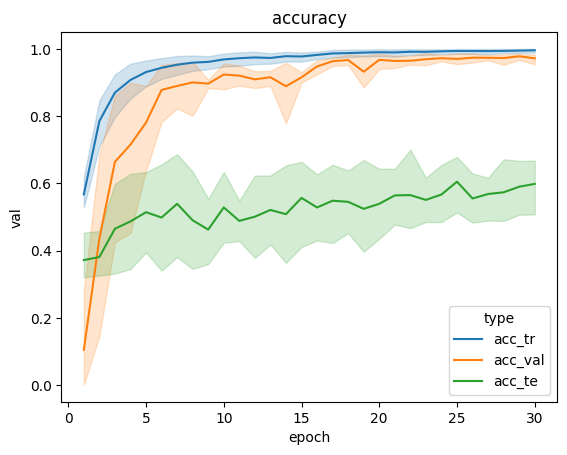

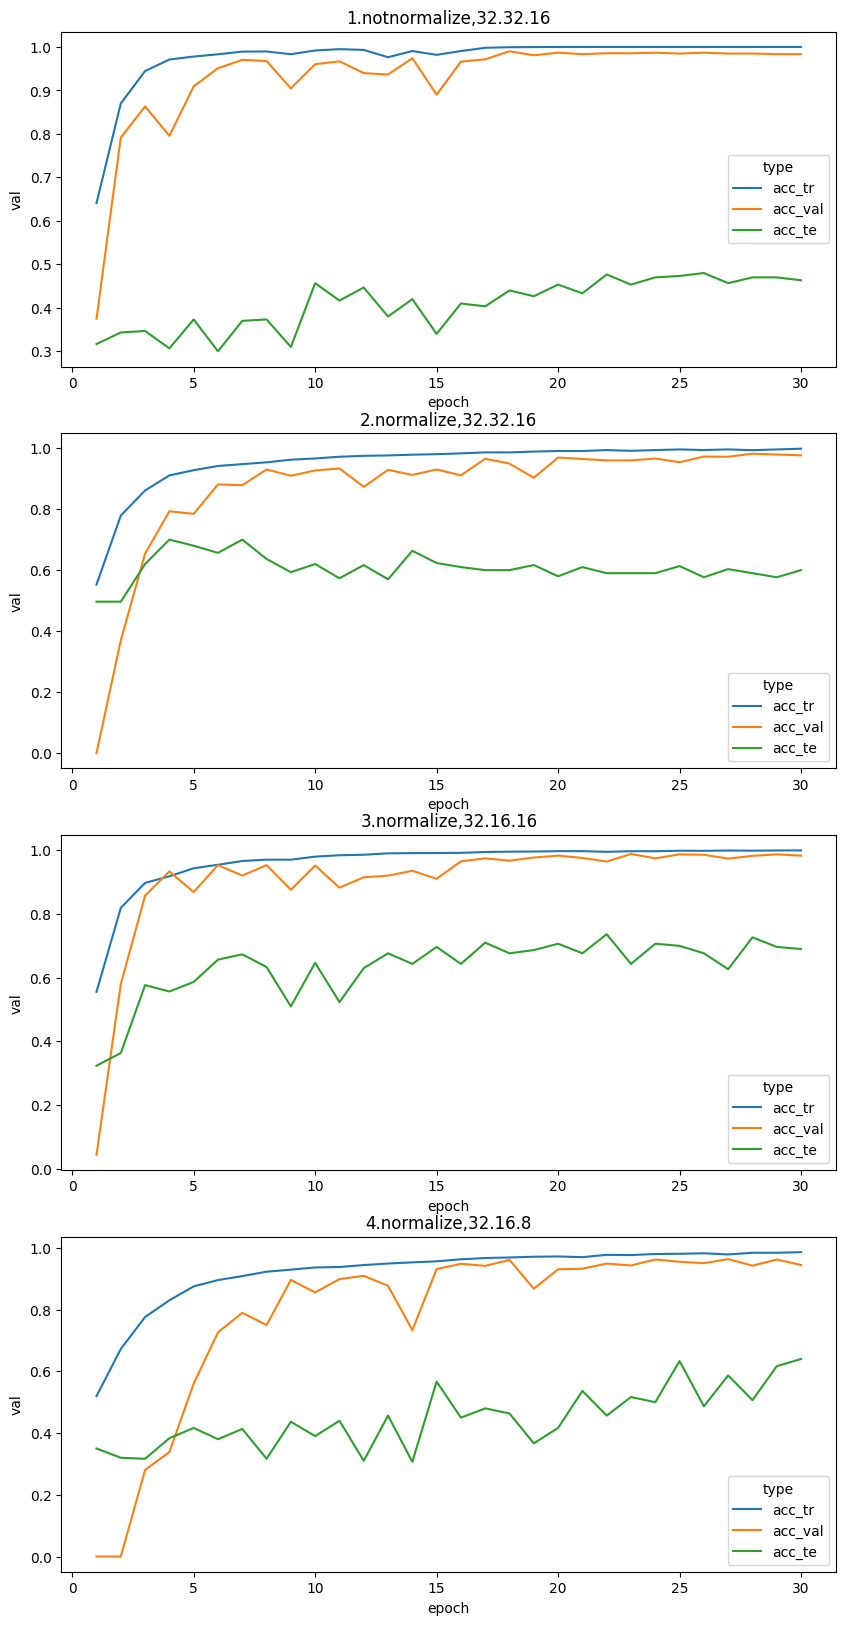

In [213]:
# accuracy, loss그래프를 그림.
graph_accuracy()


In [214]:
acc_te = result_df[ (result_df['num'] == 3) & (result_df['type'] == 'acc_te') ].sort_values(by=['val'], ascending=False)
print(acc_te)

     num  epoch    type       val
491    3     22  acc_te  0.736667
527    3     28  acc_te  0.726667
461    3     17  acc_te  0.710000
479    3     20  acc_te  0.706667
503    3     24  acc_te  0.706667
509    3     25  acc_te  0.700000
533    3     29  acc_te  0.696667
449    3     15  acc_te  0.696667
539    3     30  acc_te  0.690000
473    3     19  acc_te  0.686667
437    3     13  acc_te  0.676667
485    3     21  acc_te  0.676667
467    3     18  acc_te  0.676667
515    3     26  acc_te  0.676667
401    3      7  acc_te  0.673333
395    3      6  acc_te  0.656667
419    3     10  acc_te  0.646667
497    3     23  acc_te  0.643333
455    3     16  acc_te  0.643333
443    3     14  acc_te  0.643333
407    3      8  acc_te  0.633333
431    3     12  acc_te  0.630000
521    3     27  acc_te  0.626667
389    3      5  acc_te  0.586667
377    3      3  acc_te  0.576667
383    3      4  acc_te  0.556667
425    3     11  acc_te  0.523333
413    3      9  acc_te  0.510000
371    3      

정규화된 데이터가 정확도가 더 높음.
데이터가 많아서 conv2d 32, conv2d 16, dense 16에서 정확도 60%를 넘기는 구간이 많음.

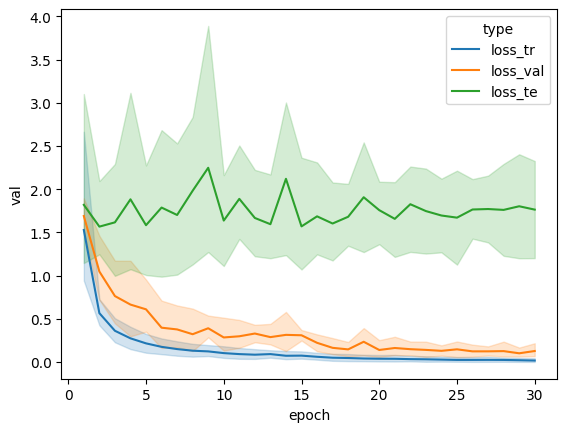

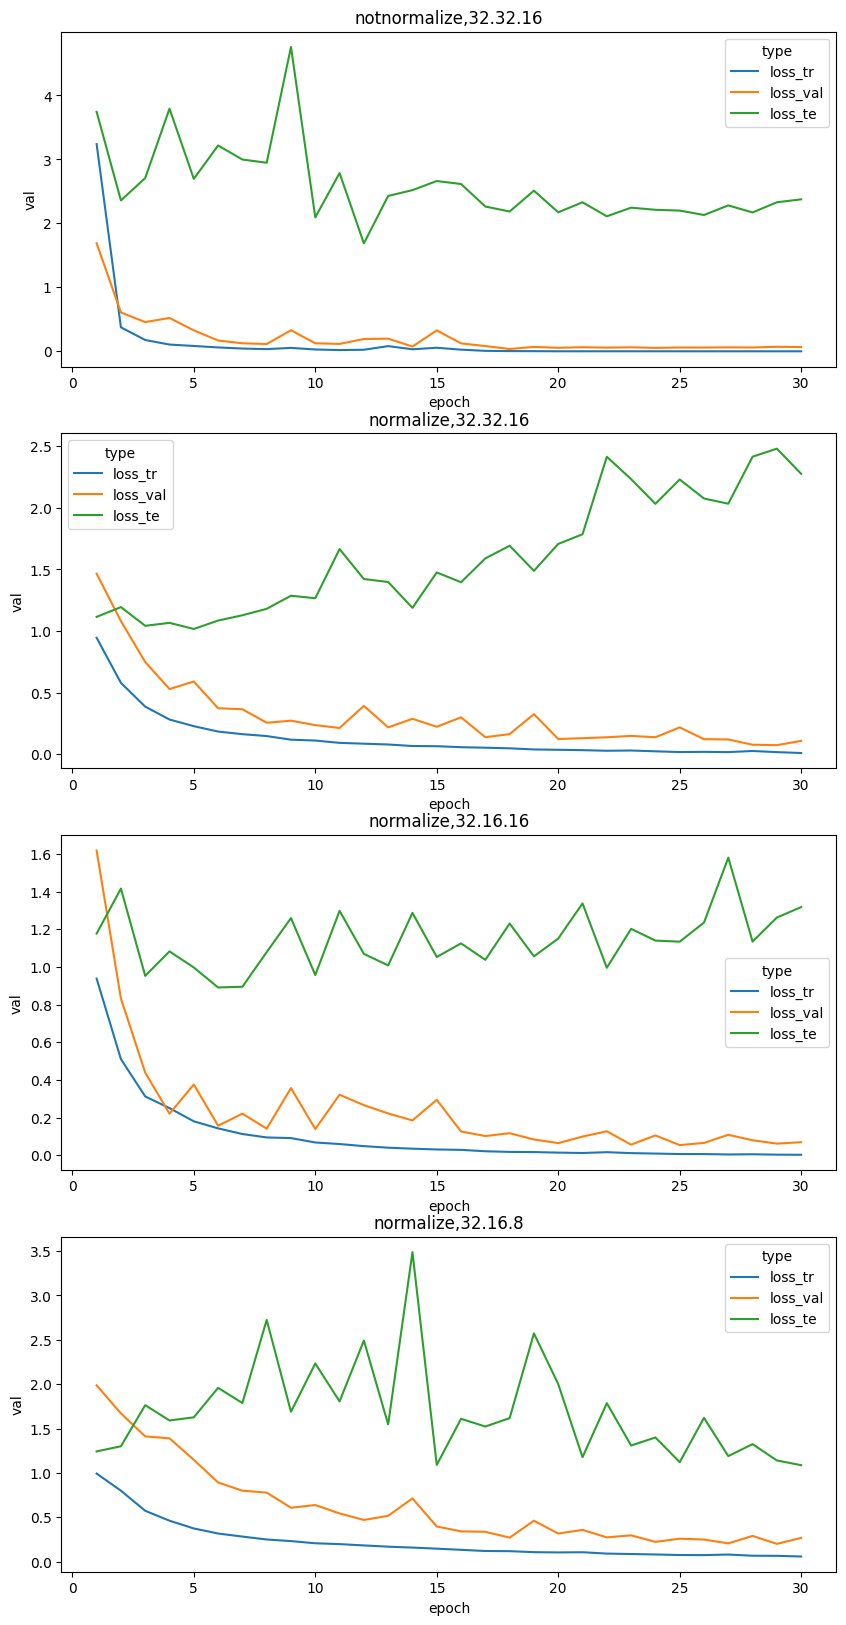

In [215]:
# loss graph를 표시.
graph_loss()

loss는 정규화된 데이터에서 훨씬 적게 나타났다.
다만 가장 결과가좋았던 32.16.16에서도 학습회수에 따라 loss가 증가하는 모습을 보여줌.

In [170]:
# 옵션들을 바꿔가며 테스트하여 결과를 누적함.

x_tr, y_tr, x_te, y_te = preprocess_data(x_train, y_train, x_test, y_test, True)

options = list()
options.append(make_option('input', (28,28,3)))
options.append(make_option('conv2d', 32, 3, 3, 'relu')) 
# options.append(make_option('batchnormal'))
options.append(make_option('maxpool2d', 2, 2))
options.append(make_option('conv2d', 16, 3, 3, 'relu'))
options.append(make_option('maxpool2d', 2, 2))
options.append(make_option('flatten'))
options.append(make_option('dense', 8, 'relu'))
# options.append(make_option('dropout', 0.1))
options.append(make_option('output', 3, 'softmax'))

model = create_model(options)

test_case = {'num' : 5, 'title': '32.16.8', 'desc' : options}

learning(model, test_case, x_tr, y_tr, x_te, y_te, epochnum)


Model Layer 개수:  7
********** ********** ********** ********** ********** .


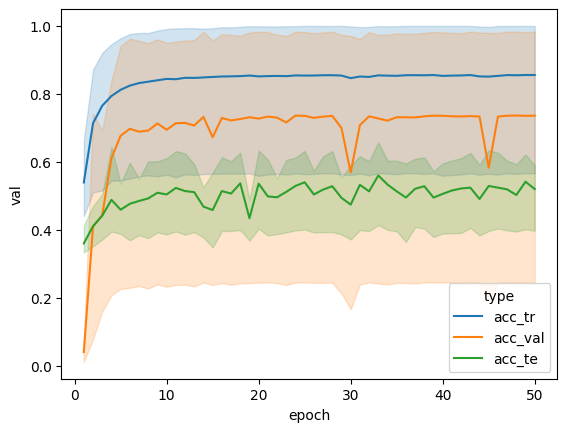

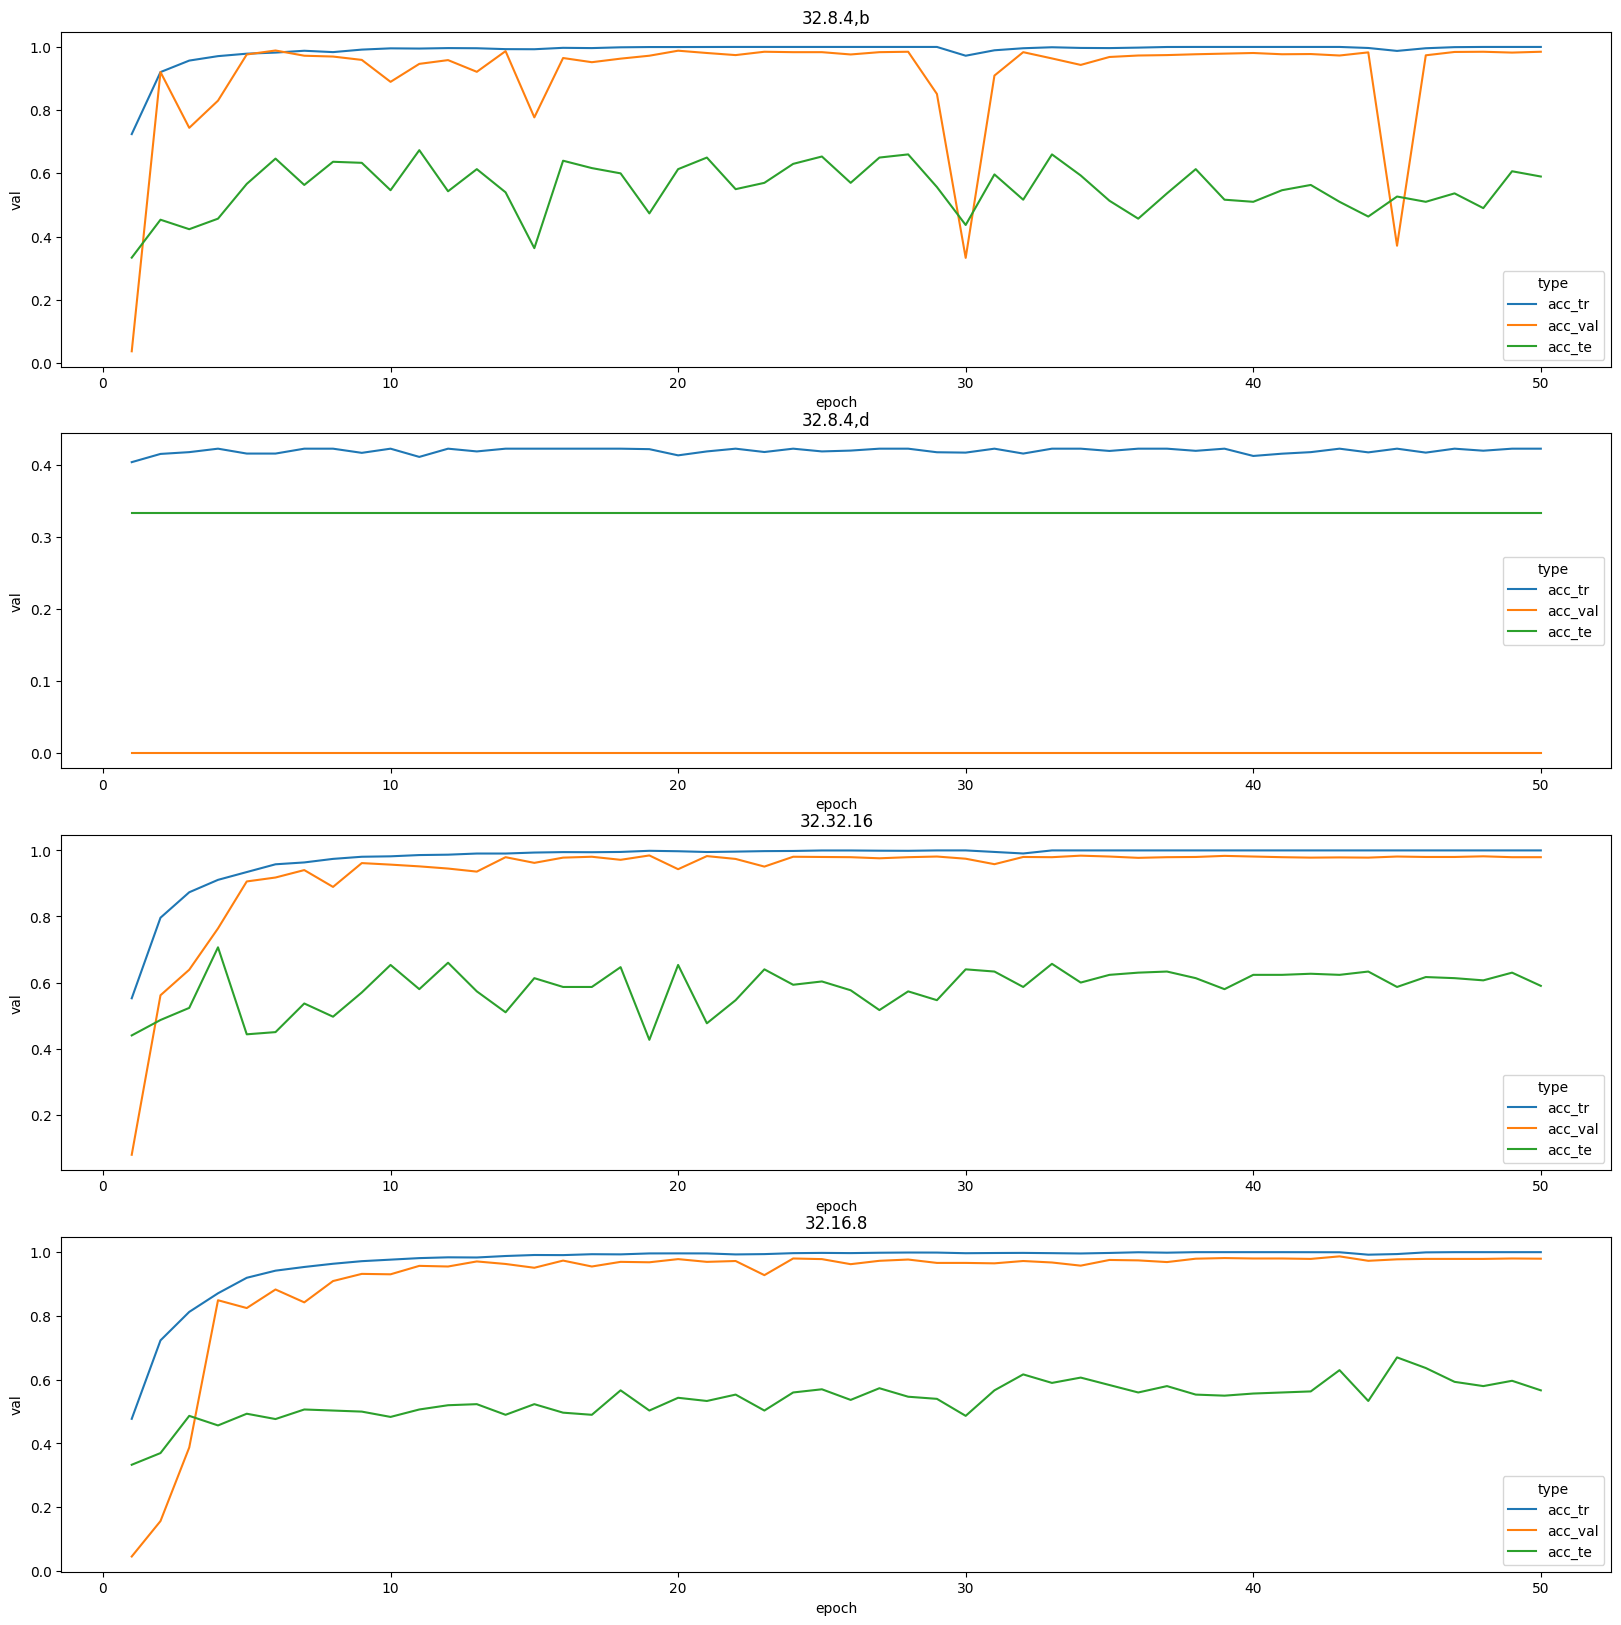

In [171]:
# accuracy 그래프를 그림.
graph_accuracy()

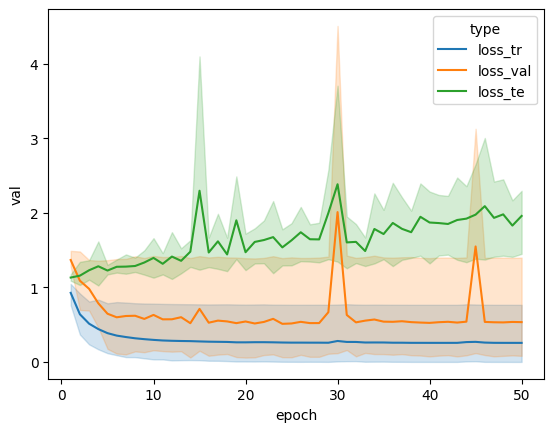

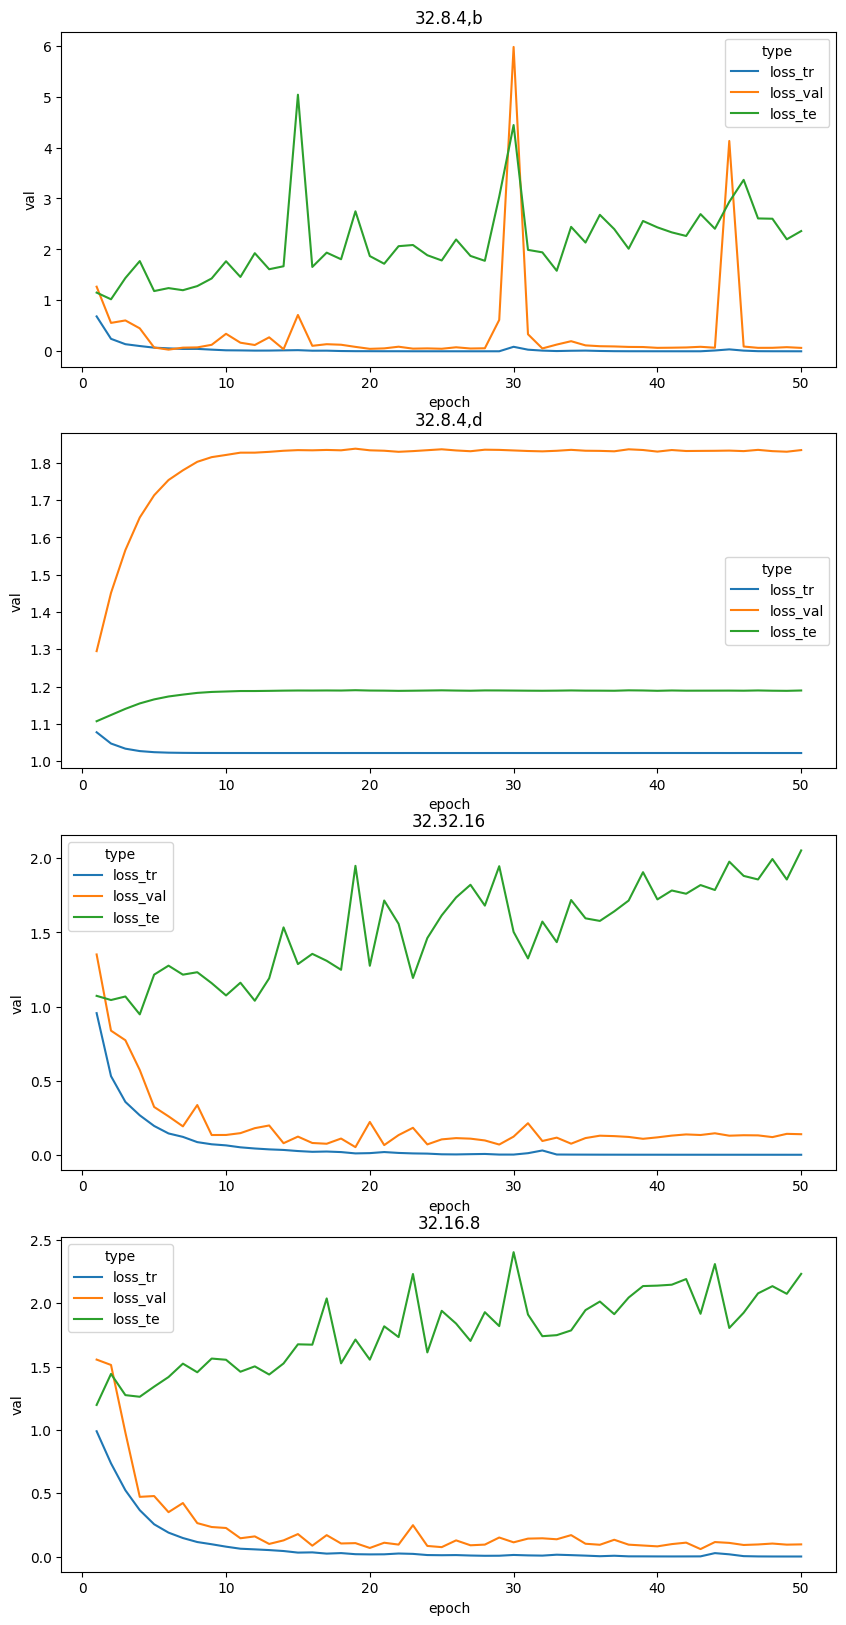

In [174]:
# loss 그래프를 그림.
graph_loss()

In [216]:
y_pr = predict_model(model, x_te)


10/10 [==============================] - 0s 15ms/step


라벨: 2, 예측결과: 1


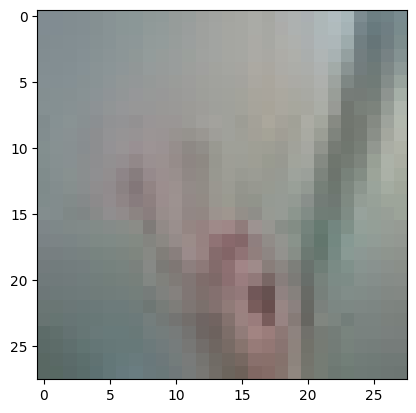

라벨: 1, 예측결과: 2


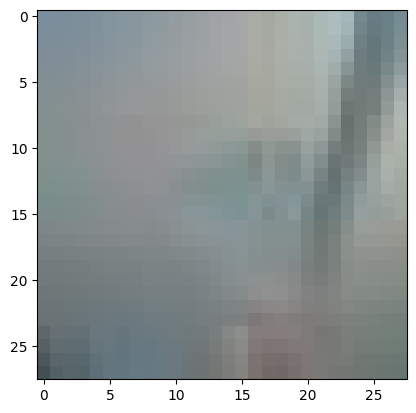

라벨: 1, 예측결과: 2


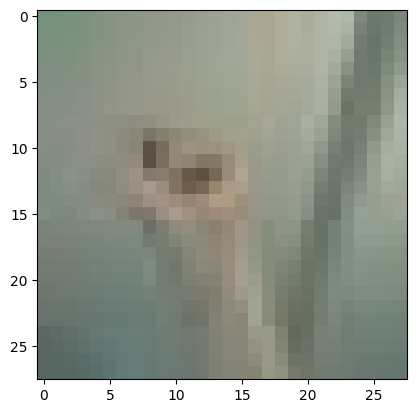

라벨: 1, 예측결과: 0


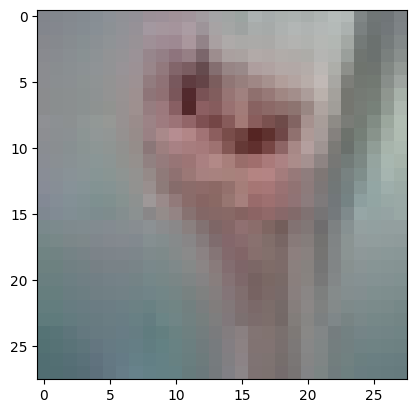

라벨: 2, 예측결과: 1


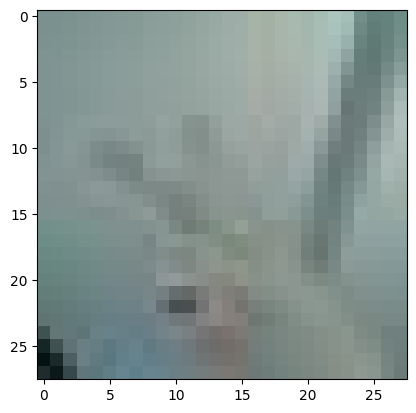

In [217]:

# show wrong cases
check_predicted(x_te, y_te, y_pr)
    

###3. 회고  

- cnn 학습모델을 테스트해봤는데 데이터가 많아서 인지 쉽게 60%를 넘을 수 있었다.  
- conv2d 32,conv2d, 16, dense 16일때 모델의 성능이 가장 좋음.
- 학습 회수가 높지 않았는데도 불구하고 가장 높은 정확도가 초반에 나왔다.
- batchnormalization을 추가하면 정확도가 갑자기 떨어지는 구간이 주기적으로 나오는듯함.
- 마지막 dense 전에 dropout을 추가한경우 특징들이 잘 압축되어 있는 데이터를 제거하여 정확도가 전체적으로 낮게 나온 것으로 보임.
- optimizer를 변경해서도 테스트를 진행하지 못했음.
- random_brightness나 contrast등을 추가하여 테스트를 한다면 test_accuracy가 다소 올라갈 것으로 예상되나 진행하지 못했음.
- 잘못 판단한 사진은 사람이 봐도 이해하기 어려운 수준으로 보임.